# Dimensionamento di un impianto solare

Questo codice risolve un problema di ottimizzazione per determinare la migliore configurazione di un sistema di generazione di energia solare con una batteria di accumulo. L'obiettivo è massimizzare l'efficienza energetica e minimizzare i costi associati all'energia elettrica.

Il problema consiste nell'ottimizzare due variabili decisionali:

1. $ P_{\text{impianto}} $: La potenza dell'impianto solare in kW.
2. $ P_{\text{batteria}} $: La potenza della batteria di accumulo in kW.

L'obiettivo è minimizzare il costo totale, che tiene conto dei seguenti fattori:

- Il costo di installazione dell'impianto solare $ C_{\text{impianto}} $.
- Il costo di installazione della batteria $ C_{\text{batteria}} $.
- Il costo dell'energia elettrica acquistata dalla rete $ C_{\text{elettrica\_acquistata}} $.
- I guadagni dalla vendita dell'energia elettrica in eccesso $ C_{\text{elettrica\_venduta}} $.
- I risparmi ottenuti utilizzando l'energia generata dall'impianto solare e dalla batteria.

Il codice utilizza la libreria `scipy` per eseguire l'ottimizzazione utilizzando il metodo `minimize`. Vengono definiti anche vincoli per garantire che le variabili decisionali siano all'interno dei limiti consentiti.

La funzione `plot` genera un grafico che visualizza la produzione di energia solare, l'energia immagazzinata nella batteria, l'energia in eccesso, la carica e lo scarico della batteria e il consumo energetico nel corso della giornata.

L'interfaccia grafica creata utilizzando `tkinter` consente all'utente di eseguire l'ottimizzazione e visualizzare i risultati, inclusi i valori ottimali delle potenze dell'impianto solare e della batteria, nonché il risparmio giornaliero.

In [23]:
%pip install --upgrade pip
%pip install scipy
%pip install matplotlib
%pip install numpy
%pip install tkinter

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tkinter (from versions: none)
ERROR: No matching distribution found for tkinter


In [24]:
import numpy as np
from scipy.optimize import linprog
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from tkinter import *
from tkinter import messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

## Descrizione dei dati
1. `ore`: Questa variabile rappresenta il numero di ore in una giornata, che è impostato a 24 ore.

2. `C_impianto`: Questa variabile rappresenta il costo dell'impianto solare in euro per kW al giorno. È calcolato dividendo il costo totale dell'impianto solare (500 euro per kW in 25 anni) per il numero di giorni in 25 anni (365 * 25).

3. `C_batteria`: Questa variabile rappresenta il costo della batteria di accumulo in euro per kW al giorno. È calcolato in modo simile a `C_impianto`, dividendo il costo totale della batteria (1000 euro per kW in 10 anni) per il numero di giorni in 10 anni (365 * 10).

4. `C_elettrica_acquistata`: Questa variabile rappresenta il costo dell'energia elettrica acquistata dalla rete in euro per kWh.

5. `C_elettrica_venduta`: Questa variabile rappresenta il valore dell'energia elettrica venduta in euro per kWh.

6. `p_max_impianto`: Questa variabile rappresenta la potenza massima dell'impianto solare in kW.

7. `p_max_batteria`: Questa variabile rappresenta la capacità massima della batteria di accumulo in kW.

8. `E_consumo`: Questa è un array che rappresenta il consumo di energia nel corso della giornata, diviso in intervalli di un minuto. Viene inizializzato con tutti gli elementi pari a \( \frac{1}{60} \), il che rappresenta il consumo di energia in kW in ciascun minuto.

In sostanza, questi dati definiscono i parametri del problema di ottimizzazione per il sistema di energia solare e batteria, inclusi costi, potenze, capacità e profili di consumo.

In [25]:
ore = 24 
C_impianto = 250/(25*365)
C_batteria = 500/(10*365) 
C_elettrica_acquistata = 0.3
C_elettrica_venduta = 0.1
p_max_impianto = 6 
p_max_batteria = 15 
E_consumo = np.zeros(ore*60)

for i in range(ore*60):
    E_consumo[i] =1/60

## Definizione funzione per la stampa dei risultati

In [26]:
def plot(P_impianto, P_batteria):
    minutes = np.arange(0, ore*60)
    solar_curve = P_impianto/60 * np.sin(np.pi * (minutes) / (12 * 60))  # Funzione sinusoidale per rappresentare la generazione solare
    solar_curve = np.maximum(solar_curve, 0)
    battery_energy = np.zeros_like(solar_curve)  
    battery_charge = np.zeros_like(solar_curve)
    battery_discharge = np.zeros_like(solar_curve)
    eccesso = np.zeros_like(solar_curve)
    
    for i in range(1, len(minutes)):
        if battery_energy[i-1]*60 < P_batteria : 
            battery_charge[i] = max(solar_curve[i] - E_consumo[i], 0)  
        else :
            eccesso[i] = max(solar_curve[i] - E_consumo[i], 0) 
        if battery_energy[i-1]>0:
            battery_discharge[i] = max(E_consumo[i] - solar_curve[i], 0)  
        battery_energy[i] = battery_energy[i-1] + battery_charge[i]/60 - battery_discharge[i]/60
        battery_energy[i] = max(0, min(battery_energy[i], P_batteria/60))

    for widget in plot_frame.winfo_children():
            widget.destroy()
    plt.clf()
    fig, ax = plt.subplots(figsize=(24, 6))
    ax.plot(minutes/60, solar_curve*60, label="Energia prodotta")
    ax.plot(minutes/60, battery_energy*60, label="Batteria")
    ax.plot(minutes/60, eccesso*60, label="eccesso")
    ax.plot(minutes/60, battery_charge*60, label="Batteria ricarica")
    ax.plot(minutes/60, battery_discharge*60, label="Batteria scarica")
    ax.plot(minutes/60, E_consumo*60, label="Consumo")
    ax.set_xlabel("ore")
    ax.set_ylabel("Potenza (kW)")
    ax.legend()
    ax.grid(True)
    canvas = FigureCanvasTkAgg(fig, master=plot_frame)
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.pack()

## Funzione obiettivo

La funzione obiettivo calcola il costo totale considerando i costi dell'impianto solare, della batteria, dell'energia elettrica acquistata, dell'energia elettrica venduta e dei risparmi ottenuti.

Sia $ P_{\text{impianto}} $ la potenza dell'impianto solare e $ P_{\text{batteria}} $ la potenza della batteria.

Siano inoltre:

- $ E_{\text{consumo}} $ l'energia consumata durante il giorno.
- $ E_{\text{impianto\_generata}} $ l'energia generata dall'impianto solare.
- $ E_{\text{impianto\_venduta}} $ l'energia in eccesso generata dall'impianto solare e venduta.
- $ E_{\text{impianto\_usata}} $ l'energia generata dall'impianto solare e utilizzata.
- $ E_{\text{batteria\_usata}} $ l'energia prelevata dalla batteria.
- $ E_{\text{acquistata}} $ l'energia elettrica acquistata dalla rete.
- $ E_{\text{risparmiata}} $ l'energia elettrica risparmiata grazie all'impianto solare e alla batteria.

La funzione obiettivo è quindi:

$
\text{Costo totale} = C_{\text{impianto}} \cdot P_{\text{impianto}} + C_{\text{batteria}} \cdot P_{\text{batteria}} + E_{\text{acquistata}} \cdot C_{\text{elettrica\_acquistata}} - C_{\text{elettrica\_venduta}} \cdot E_{\text{impianto\_venduta}} - E_{\text{risparmiata}} \cdot C_{\text{elettrica\_acquistata}}
$

dove:
- $ C_{\text{impianto}} $ è il costo dell'impianto solare in euro/kW al giorno.
- $ C_{\text{batteria}} $ è il costo della batteria di accumulo in euro/kW al giorno.
- $ C_{\text{elettrica\_acquistata}} $ è il costo dell'energia elettrica acquistata dalla rete in euro/kWh.
- $ C_{\text{elettrica\_venduta}} $ è il valore dell'energia elettrica venduta in euro/kWh.

Questa funzione rappresenta il costo totale che si desidera minimizzare durante l'ottimizzazione.

In [27]:
def objective(x, C_impianto, C_batteria, C_elettrica_acquistata, E_consumo,C_elettrica_venduta):
    P_impianto, P_batteria = x
    
    minutes = np.arange(0, ore*60)
    solar_curve = P_impianto/60 * np.sin(np.pi * (minutes) / (12 * 60))  # Funzione sinusoidale per rappresentare la generazione solare
    solar_curve = np.maximum(solar_curve, 0)
    battery_energy = np.zeros_like(solar_curve)  
    battery_charge = np.zeros_like(solar_curve)
    battery_discharge = np.zeros_like(solar_curve)
    eccesso = np.zeros_like(solar_curve)
    
    for i in range(1, len(minutes)):
        if battery_energy[i-1]*60 < P_batteria : 
            battery_charge[i] = max(solar_curve[i] - E_consumo[i], 0)  
        else :
            eccesso[i] = max(solar_curve[i] - E_consumo[i], 0) 
        if battery_energy[i-1]>0:
            battery_discharge[i] = max(E_consumo[i] - solar_curve[i], 0)  
        battery_energy[i] = battery_energy[i-1] + battery_charge[i]/60 - battery_discharge[i]/60
        battery_energy[i] = max(0, min(battery_energy[i], P_batteria/60))
    
    E_impianto_generata = np.sum(solar_curve) 
    E_impianto_venduta = np.sum(eccesso)  
    E_impianto_usata = E_impianto_generata - np.sum(battery_charge) - np.sum(eccesso) 
    E_batteria_usata = np.sum(battery_discharge)
    E_acquistata=np.sum(E_consumo) - E_impianto_usata - E_batteria_usata
    E_risparmiata=np.sum(E_consumo) - E_acquistata
    
    costo_totale = C_impianto * P_impianto + C_batteria * P_batteria + E_acquistata * C_elettrica_acquistata - C_elettrica_venduta * E_impianto_venduta - E_risparmiata* C_elettrica_acquistata
    #print("P_impianto:",P_impianto,"P_batteria:", P_batteria,"Costo totale iterazione:", costo_totale,"E_impianto_generata:", E_impianto_generata,"E_impianto_usata:", E_impianto_usata, "E_impianto_venduta",E_impianto_venduta,"E_batteria_usata",E_batteria_usata,"E_acquistata",E_acquistata)
    return costo_totale

## Definizione dei vincoli

1. Il primo vincolo impone che se la potenza dell'impianto solare è zero, allora la potenza della batteria deve essere zero:
   $$
   P_{\text{impianto}} = 0 \Rightarrow P_{\text{batteria}} = 0
   $$
   
2. Il secondo vincolo impone che la potenza dell'impianto solare e la potenza della batteria devono essere entrambe non negative:

   $$
   P_{\text{impianto}} \geq 0 \\
   P_{\text{batteria}} \geq 0
   $$

3. Il terzo vincolo impone che la potenza massima dell'impianto solare meno la potenza dell'impianto solare scelta deve essere maggiore o uguale a zero, e la capacità massima della batteria meno la potenza della batteria scelta deve essere maggiore o uguale a zero:

   $$
   p_{\text{max\_impianto}} - P_{\text{impianto}} \geq 0 \\
   p_{\text{max\_batteria}} - P_{\text{batteria}} \geq 0
   $$

In [28]:
def constraint(x):
    P_impianto, P_batteria = x
    if P_impianto == 0:
        return P_impianto
    else:
        return P_batteria

def constraint1(x):
    P_impianto, P_batteria = x
    return [P_impianto, P_batteria]

def constraint2(x):
    P_impianto, P_batteria = x
    return [p_max_impianto - P_impianto, p_max_batteria - P_batteria]

cons = [
        {'type': 'ineq', 'fun': constraint},
        {'type': 'ineq', 'fun': constraint1},
        {'type': 'ineq', 'fun': constraint2}
       ]

bounds = [(0, p_max_impianto), (0, p_max_batteria)]

## Valori iniziali delle variabili decisionali

In [29]:
x0 = [0, 0]
options = {'eps': [1, 1]}

## Interfaccia grafica

<Figure size 640x480 with 0 Axes>

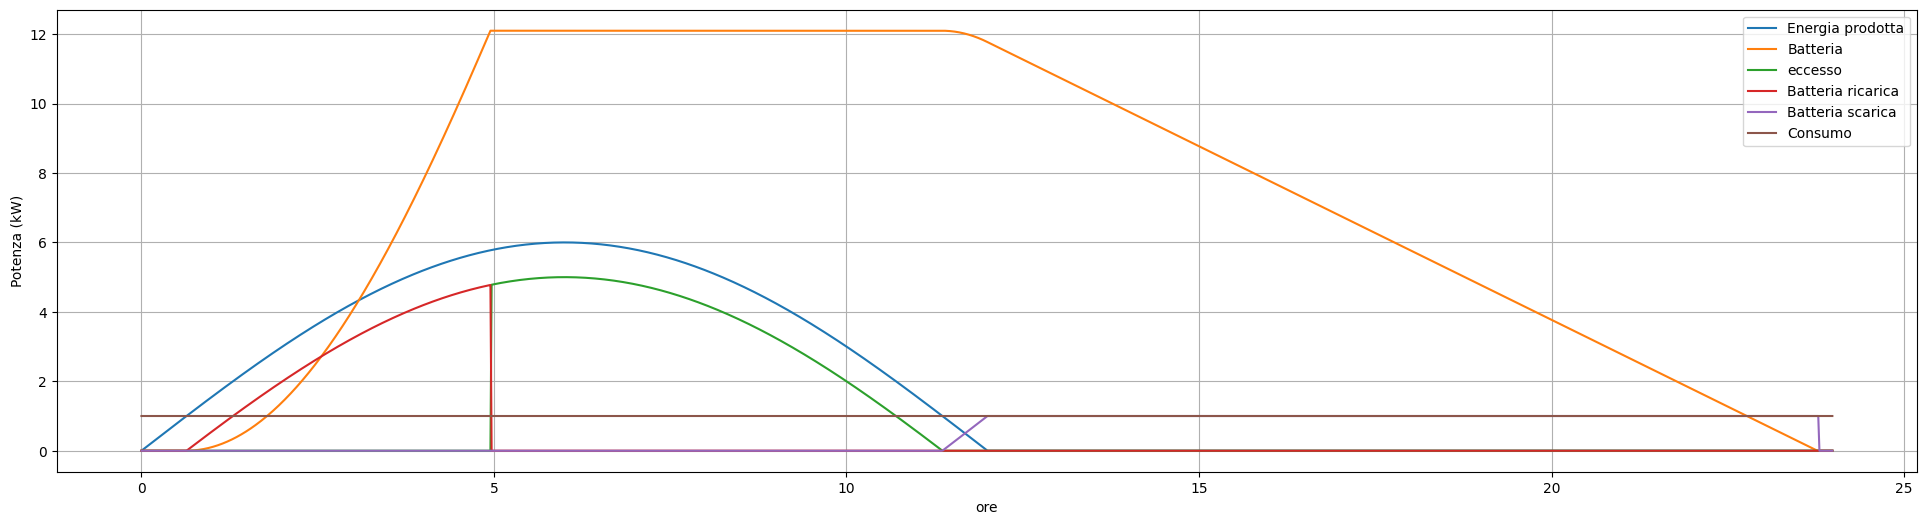

In [30]:
def run_optimization():
    try:
        res = minimize(objective, x0, args=(C_impianto, C_batteria, C_elettrica_acquistata, E_consumo, C_elettrica_venduta), bounds=bounds, constraints=cons, tol=1e-2, options=options)

        result_text.set(f"Potenza dell'impianto solare ottimale: {res.x[0]:.2f} kW\n"
                        f"Potenza della batteria di accumulo ottimale: {res.x[1]:.2f} kW\n"
                        f"Risparmio giornaliero: {res.fun:.2f} euro")
        plot(res.x[0],res.x[1])
        
    except Exception as e:
        messagebox.showerror("Error", f"Si è verificato un errore: {e}")

root = Tk()
root.title("Solar Power Optimization")

frame = Frame(root)
frame.pack(padx=20, pady=20)

run_button = Button(frame, text="Esegui Ottimizzazione", command=run_optimization)
run_button.pack()

result_text = StringVar()
result_label = Label(frame, textvariable=result_text)
result_label.pack()

plot_frame = Frame(root)
plot_frame.pack()

root.mainloop()

## Esempio caso reale vs modello

batteria da 12kw e impianto solare da 6kw

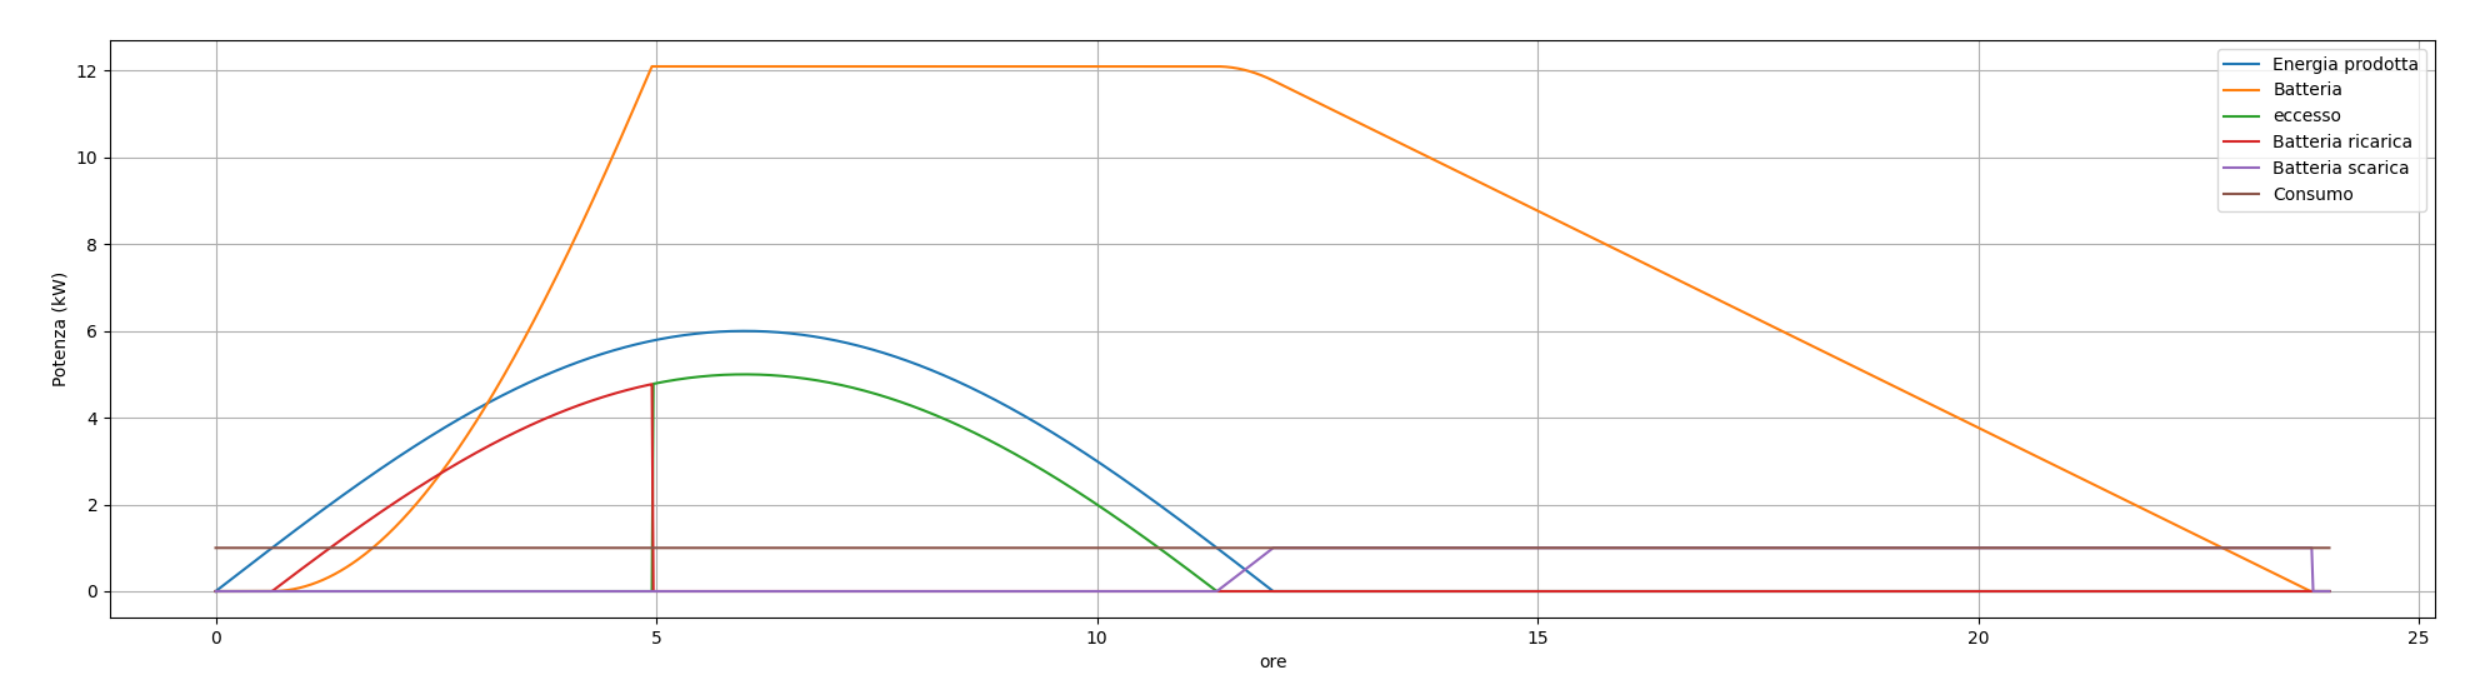

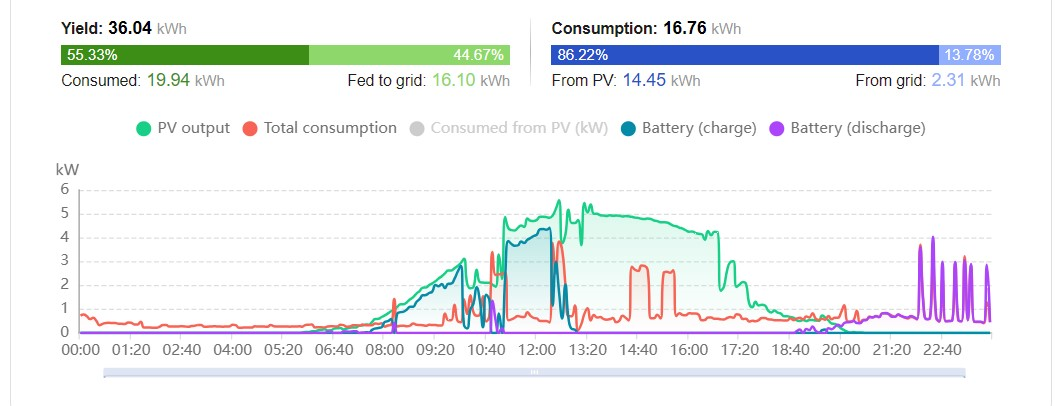